# Particle simulation vs Langevin model

In [1]:
include("../src/bmparticles.jl")
include("../src/bmtheory.jl")
using .BParts
using .Theorist
using DifferentialEquations, Distributions

## Growing population

### Parameters

In [2]:
using Plots
# plotly()
gr()
# plotlyjs()

Plots.GRBackend()

In [3]:
function extendParams!(arenaParams::Dict)
    bounds = arenaParams["bounds"]
    arenaParams["volume"] = abs(bounds[1][2]-bounds[1][1])*abs(bounds[2][2]-bounds[2][1])
    arenaParams["bperiod"] = [abs(bounds[1][2]-bounds[1][1]), abs(bounds[2][2]-bounds[2][1])]
end

arenaParams = 
    Dict(
        "n0"=>50,
        "evolveTime"=>300,
        "bounds"=>((0.,20.),(0.,20.)), 
        "radius"=>0.08, 
        "speed"=>0.03
    )

growthParams =
    Dict(
        "ρ"=> 0.06,
        "k"=> 2000
    )

extendParams!(arenaParams)

println(arenaParams)
println(growthParams)

Dict{String,Any}("volume" => 400.0,"evolveTime" => 300,"speed" => 0.03,"radius" => 0.08,"bounds" => ((0.0, 20.0), (0.0, 20.0)),"bperiod" => [20.0, 20.0],"n0" => 50)
Dict{String,Real}("k" => 2000,"ρ" => 0.06)


### Logistic Growth

The number of cells in the system increases according to the logistic growth function:
\begin{equation}
n(t) = \frac{k}{ 1 + \frac{k-n_0}{n_0}e^{-\rho t}}
\end{equation}


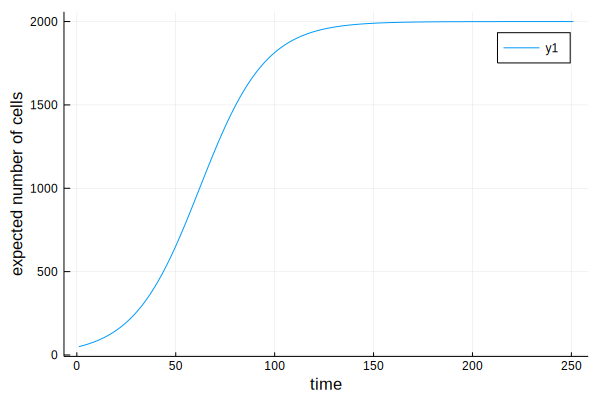

In [4]:
p = plot(Theorist.logisticGrowth.(0:250,growthParams["ρ"], growthParams["k"], arenaParams["n0"]))
xlabel!("time")
ylabel!("expected number of cells")
display(p)

Run Langevin simulations:

In [5]:
langevinEnsemble = Theorist.runLangevinSims(1000, arenaParams, growthParams);

Run a particle simulation:

In [9]:
arena, pos_t_dim_id, vel_t_dim_id, cells_T_ID = BParts.randArenaEvolve(arenaParams["n0"], arenaParams["evolveTime"], arenaParams, growthParams);

Progress:  35%|██████████████▌                          |  ETA: 0:00:02

anomalous collision time 1.0069755204621917 found in step time 1


Progress:  49%|████████████████████                     |  ETA: 0:00:03

anomalous collision time 5.245991572853841 found in step time 1
anomalous collision time 9.251775550013912 found in step time 1
anomalous collision time 2.6553519477411127 found in step time 1
anomalous collision time 2.921332533860065 found in step time 1
anomalous collision time 5.653381482069039 found in step time 1
anomalous collision time 2.306737447118398 found in step time 1
anomalous collision time 2.4355549458758614 found in step time 1
anomalous collision time 6.8677877634063025 found in step time 1
anomalous collision time 4.4589070688553125 found in step time 1
anomalous collision time 6.867787763406317 found in step time 1
anomalous collision time 4.4589070688553365 found in step time 1
anomalous collision time 6.867787763406295 found in step time 1


Progress:  49%|████████████████████▏                    |  ETA: 0:00:03

anomalous collision time 11.606299232498813 found in step time 1
anomalous collision time 13.685106083922918 found in step time 1
anomalous collision time 1.0529193273654045 found in step time 1
anomalous collision time 3.6638874547026625 found in step time 1


Progress:  64%|██████████████████████████▏              |  ETA: 0:00:02

anomalous collision time 1.4821787290884036 found in step time 1
anomalous collision time 3.9078114045252996 found in step time 1
anomalous collision time 2.3498507912601645 found in step time 1
anomalous collision time 4.091937310103217 found in step time 1
anomalous collision time 4.091937310103237 found in step time 1
anomalous collision time 4.091937310103227 found in step time 1


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

anomalous collision time 1.0424889484327258 found in step time 1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


### Mean squared displacement

In [10]:
msdTime = arenaParams["evolveTime"]
timesMSD_t, msdLan_t = Theorist.msd(langevinEnsemble, arenaParams,  (0, msdTime-1), msdTime);
msdPar_t = BParts.meanSquaredDisplacement(pos_t_dim_id[1:msdTime,:,:], arenaParams["bperiod"]);

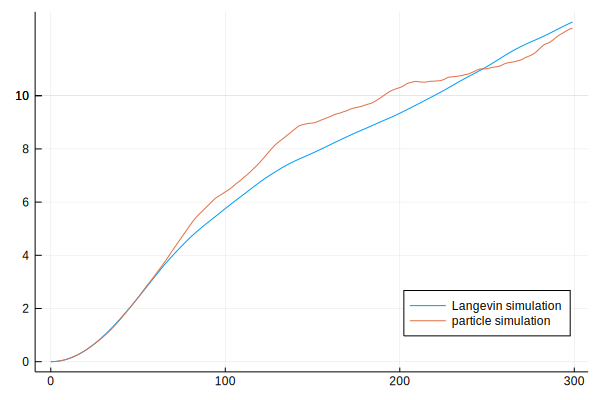

In [11]:
p2 = plot(timesMSD_t, msdLan_t, label="Langevin simulation", legend=:bottomright)
plot!(timesMSD_t, msdPar_t, label="particle simulation")
display(p2)

The particle simulation does not always exactly match the Langevin ensembles. This is likely due to the fact that currently cells are still added stochastically as a Poisson process. A deterministic version should be implemented to compare more directly.